In [1]:
import BioSimSpace as bss
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

INFO:rdkit:Enabling RDKit 2022.09.1 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
_K_B = scipy.constants.Boltzmann
_TEMPERATURE = 300
_N_A = scipy.constants.Avogadro


def inhibition_to_ddg(ki_a: float, ki_b: float) -> float:
    """
    convert experimental Ki values to binding free-energy difference
    :param ki_a: experimental Ki of ligand 1
    :param ki_b: experimental Ki of ligand 2
    :return: experimental RBFE value
    """
    ic50_a = 2 * ki_a
    ic50_b = 2 * ki_b

    return (_K_B * _N_A * _TEMPERATURE / 4184) * np.log(ic50_b / ic50_a)


def get_experimental_error(error_a, ki_a, error_b, ki_b):
    fraction = ki_b / ki_a
    fraction_error = fraction * np.sqrt((error_b / ki_b) ** 2 + (error_a / ki_a) ** 2)
    return (_K_B * _TEMPERATURE * fraction_error / fraction) * _N_A / 4184

In [37]:
free_directory = "/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_1~lig_2/unbound/"
bound_directory = "/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_1~lig_2/bound/"

header_file = "/home/jguven/projects/metalloenzymes/scripts/simfile_header.txt"
with open(header_file, "r") as file:
    header = file.readlines()

unbound_min_simfiles = sorted(glob.glob(free_directory + "/minimisation/lambda_*/simfile.dat"))

unbound_simfiles = sorted(glob.glob(free_directory + "lambda_*/simfile.dat"))

bound_simfiles = sorted(glob.glob(bound_directory + "lambda_*/simfile.dat"))

for i in range(len(unbound_min_simfiles)):

    with open(unbound_min_simfiles[i], "r") as file:
        min_simfile_lines = file.readlines()

    with open(unbound_min_simfiles[i], "r") as file:
        for j, line in enumerate(file):
            if "lambda" in line:
                start = j
            if "#" not in line:
                end = j
                break

    lambda_header = min_simfile_lines[start:end]
    full_header = header + lambda_header

    with open(unbound_simfiles[i], "r+") as file:
        data = file.readlines()
        file.seek(0, 0)
        header_and_data = full_header + data
        file.writelines(header_and_data)

    with open(bound_simfiles[i], "r+") as file:
        data = file.readlines()
        file.seek(0, 0)
        header_and_data = full_header + data
        file.writelines(header_and_data)


# for simfile in unbound_simfiles:

# for simfile in bound_simfiles:
#     with open(simfile, "r+") as file:
#         data = file.readlines()
#         file.seek(0, 0)
#         header_and_data = header + data
#         file.writelines(header_and_data)



In [13]:

unbound_simfiles = glob.glob(free_directory + "lambda_*/simfile.dat")
bound_simfiles = glob.glob(bound_directory + "lambda_*/simfile.dat")

for simfile in unbound_simfiles:
    with open(simfile, "r+") as file:
        data = file.readlines()
        file.seek(0, 0)
        header_and_data = header + data
        file.writelines(header_and_data)

for simfile in bound_simfiles:
    with open(simfile, "r+") as file:
        data = file.readlines()
        file.seek(0, 0)
        header_and_data = header + data
        file.writelines(header_and_data)



In [38]:
pmf_bound, overlap_matrix_bound = bss.FreeEnergy.Relative.analyse(bound_directory) 
pmf_free, overlap_matrix_free = bss.FreeEnergy.Relative.analyse(free_directory)

In [39]:
paths = ["/home/jguven/projects/metalloenzymes/kpc2/outputs/SOMD/lig_1~lig_2/"]
analysis_file = "../kpc2/afe/somd_results_analysis.txt"
with open(analysis_file, "w") as file:
    for path in paths:
        transformation = path.split("/")[-2]
        file.write(transformation+"\n")
        free_directory = path + "unbound/"
        bound_directory = path + "bound/"
        try:
            pmf_free, overlap_matrix_free = bss.FreeEnergy.Relative.analyse(free_directory)
            pmf_bound, overlap_matrix_bound = bss.FreeEnergy.Relative.analyse(bound_directory)    
            free_energy_difference, free_energy_error = bss.FreeEnergy.Relative.difference(pmf_bound, pmf_free)
            file.write(f"{free_energy_difference} \u00B1 {free_energy_error} \n")    
        except IndexError as e:
            file.write(str(e)+"\n")
        except ValueError as e:
            file.write(str(e)+"\n")

In [40]:
with open(analysis_file, "r") as file:
    lines = file.readlines()
results = [line for line in lines[1:len(lines):2]]
free_energy_differences = []
free_energy_errors = []
for result in results:
    split_results = result.split("±")
    free_energy_differences.append(float(split_results[0].replace("kcal/mol", "").replace("⁻¹ \n", "")))
    free_energy_errors.append(float(split_results[1].replace("kcal/mol", "").replace("⁻¹ \n", "").replace("kcal mol", "")))
    

In [41]:
perturbations = [line for line in lines[0:len(lines):2]]
for line in perturbations:
    print(line)

lig_1~lig_2



In [42]:
first_indices = []
second_indices = []
for line in perturbations:
    no_newline = line.strip("\n")
    lig_1 = no_newline.split("~")[0].replace("lig_", "")
    lig_2 = no_newline.split("~")[1].replace("lig_", "")  
    first_indices.append(int(lig_1) - 1)
    second_indices.append(int(lig_2) - 1)

for i in range(len(first_indices)):
    print(first_indices[i], second_indices[i])

0 1


In [43]:
experimental_file = pd.read_csv("../kpc2/afe/experimental_ki.txt")
experimental_ki, experimental_ki_error = experimental_file["K_i"], experimental_file["K_i_err"]
print(experimental_file)

    ligand      K_i  K_i_err
0        1   32.900    3.300
1        2    8.400    0.400
2        3   15.300    2.500
3        4   23.300    4.600
4        5  154.400    0.000
5        6    1.400    0.200
6        7   11.900    1.100
7        8    9.300    1.800
8        9    0.246    0.047
9       10    8.500    0.300
10      11  142.300   22.300
11      12  101.500    8.600
12      13    2.200    0.800
13      14  730.400   87.400
14      15  326.100   56.800
15      16    0.020    0.007


In [44]:
experimental_free_energies = []
experimental_errors = []
for i in range(len(first_indices)):
    i_1, i_2 = first_indices[i], second_indices[i]
    experimental_free_energy = inhibition_to_ddg(experimental_ki[i_1], experimental_ki[i_2])
    # error_a, ki_a, error_b, ki_b
    experimental_error = get_experimental_error(experimental_ki_error[i_1], experimental_ki[i_1], experimental_ki_error[i_2], experimental_ki[i_2])
    experimental_free_energies.append(experimental_free_energy)
    experimental_errors.append(experimental_error)
                                                

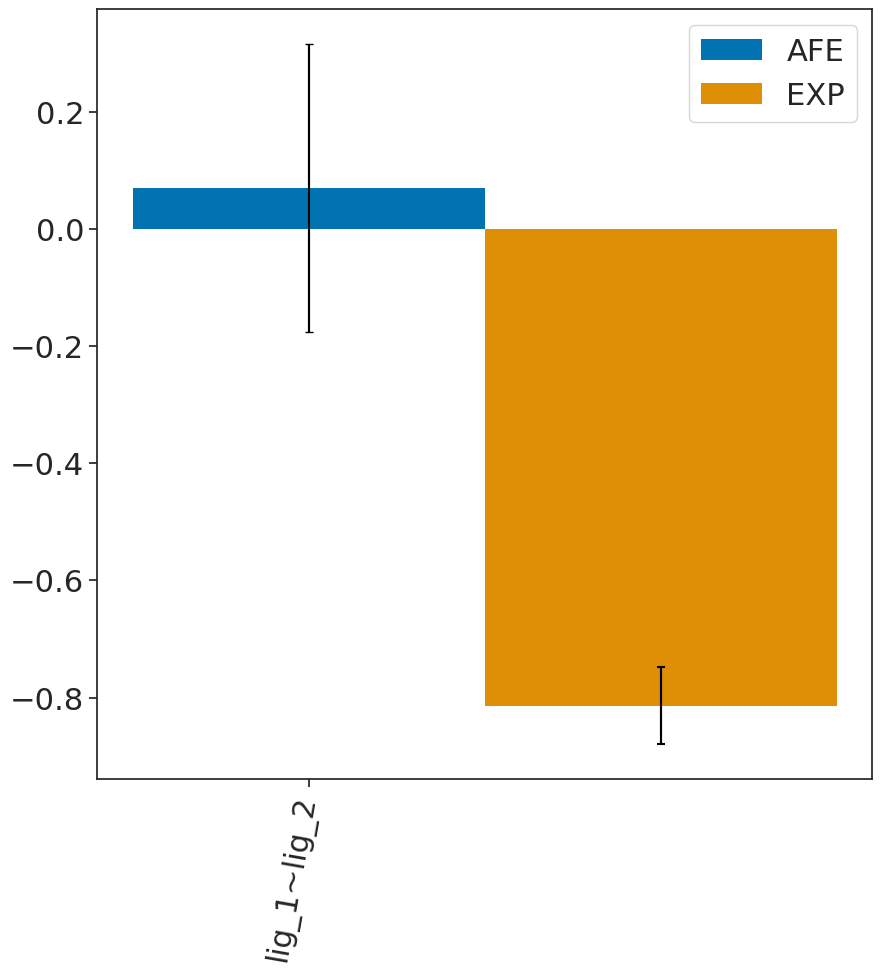

In [45]:
fig = plt.figure(figsize=(10, 10))
sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)
x_label_locations = np.arange(len(free_energy_differences))
bar_width = 0.35

plt.bar(x_label_locations - bar_width / 2,
        height=free_energy_differences,
        width=bar_width,
        yerr=free_energy_errors,
        label="AFE",
        # color="#0099AB",
        linewidth=0)

(_, caps, _) = plt.errorbar(x_label_locations - bar_width / 2,
                            free_energy_differences,
                            color="black",
                            yerr=free_energy_errors,
                            capsize=3,
                            linestyle="")

plt.bar(x_label_locations + bar_width / 2,
        height=experimental_free_energies,
        width=bar_width,
        yerr=experimental_errors,
        label="EXP",
        # color="#0099AB",
        linewidth=0)

(_, caps, _) = plt.errorbar(x_label_locations + bar_width / 2,
                            experimental_free_energies,
                            color="black",
                            yerr=experimental_errors,
                            capsize=3,
                            linestyle="")

for cap in caps:
    cap.set_color("black")
    cap.set_markeredgewidth(1.5)
# plt.ylim(-6, 6)
plt.xticks(x_label_locations - bar_width / 2, perturbations, rotation=80, ha="center")
plt.legend()


(-4.5, 4.5)

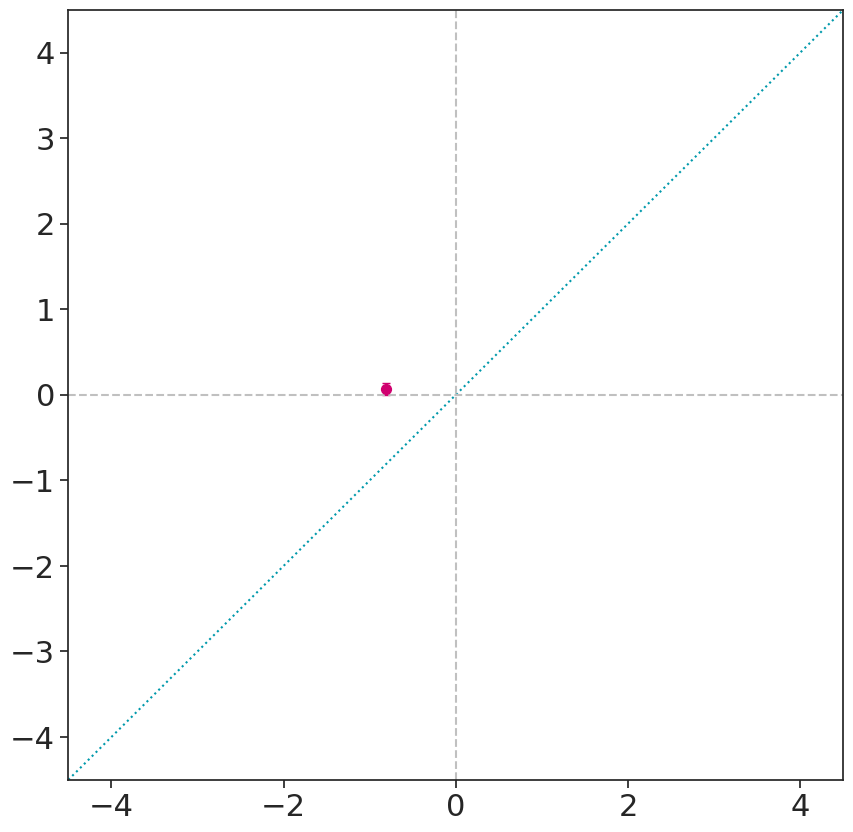

In [46]:
plt.figure(figsize=(10, 10))
sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)
plt.scatter(experimental_free_energies, free_energy_differences, s=50, color="#D0006F")
# plt.scatter(3, 2.5, s=0)

(_, caps, _) = plt.errorbar(experimental_free_energies,
                           free_energy_differences,
                           color="#D0006F",
                           yerr=free_energy_differences,
                           capsize=3,
                           linestyle="",
                           zorder=-1)

plt.plot([-4.5, 4.5], [-4.5, 4.5], color="#0099AB", linestyle=":", zorder=-1)
plt.vlines(0, -4.5, 4.5, color = "silver", linestyle="--", zorder=-1)
plt.hlines(0, -4.5, 4.5, color = "silver", linestyle="--", zorder=-1)
plt.xlim(-4.5, 4.5)
plt.ylim(-4.5, 4.5)


In [28]:
pearson_r = scipy.stats.pearsonr(experimental_free_energies, free_energy_differences)
pearson_r

PearsonRResult(statistic=0.13419561216445033, pvalue=0.5515792844635533)